# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


In [19]:
type(states)

numpy.ndarray

When finished, you can close the environment.

In [6]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import namedtuple, deque
import matplotlib.pyplot as plt

In [6]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-2              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
LEARN_EVERY = 4        # how often to learn from the experience
UPDATE_EVERY = 2        # how often to update the target network
random_seed = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [8]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed=0, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed=0, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.leaky_relu(self.fc1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)

In [9]:
class TD3Agent():
    """Interacts with and learns from the environment."""
    # Shared crtic among all agents
    critic_local1 = None
    critic_target1 = None
    critic_optimizer1 = None
    
    critic_local2 = None
    critic_target2 = None
    critic_optimizer2 = None
    
    def __init__(self, state_size, action_size, max_action, min_action, memory, random_seed, noise=0.2, noise_std=0.3, noise_clip=0.5):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            max_action (ndarray): the maximum valid value for each action vector
            min_action (ndarray): the minimum valid value for each action vector
            random_seed (int): random seed
            noise (float): the range to generate random noise while learning
            noise_std (float): the range to generate random noise while performing action
            noise_clip (float): to clip random noise into this range
        """
        self.state_size = state_size
        self.action_size = action_size
        self.max_action = max_action
        self.min_action = min_action
        self.noise = noise
        self.noise_std = noise_std
        self.noise_clip = noise_clip
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        if TD3Agent.critic_local1 is None:
            TD3Agent.critic_local1 = Critic(state_size, action_size).to(device)
        if TD3Agent.critic_target1 is None:
            TD3Agent.critic_target1 = Critic(state_size, action_size).to(device)
            TD3Agent.critic_target1.load_state_dict(self.critic_local1.state_dict())
        if TD3Agent.critic_optimizer1 is None:
            TD3Agent.critic_optimizer1 = optim.Adam(self.critic_local1.parameters(), lr=LR_CRITIC)
        self.critic_local1 = TD3Agent.critic_local1
        self.critic_target1 = TD3Agent.critic_target1
        self.critic_optimizer1 = TD3Agent.critic_optimizer1
        
        if TD3Agent.critic_local2 is None:
            TD3Agent.critic_local2 = Critic(state_size, action_size).to(device)
        if TD3Agent.critic_target2 is None:
            TD3Agent.critic_target2 = Critic(state_size, action_size).to(device)
            TD3Agent.critic_target2.load_state_dict(self.critic_local2.state_dict())
        if TD3Agent.critic_optimizer2 is None:
            TD3Agent.critic_optimizer2 = optim.Adam(self.critic_local2.parameters(), lr=LR_CRITIC)
        self.critic_local2 = TD3Agent.critic_local2
        self.critic_target2 = TD3Agent.critic_target2
        self.critic_optimizer2 = TD3Agent.critic_optimizer2
        
        # Shared Replay memory
        self.memory = memory
        
        self.lt_step = 0
        self.ut_step = 0
        
        
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory"""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every LEARN_EVERY times
        self.lt_step = (self.lt_step + 1) % LEARN_EVERY
        if self.lt_step == 0:
            # Learn, if enough samples are available in memory
            if len(self.memory) > BATCH_SIZE:
                # update network UPDATE_EVERY times
                for t in range(UPDATE_EVERY):
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA)
            
    def act(self, state, noise_reduction=0.0, add_noise=True):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (ndarray): the observation of current state
            noise_reduction (float): the number for adjusting noise while training
            add_noise (bool): whether to add noise in action
        """
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        if add_noise:
            # Generate a random noise
            noise = np.random.normal(0, self.noise_std, size=self.action_size)
            noise *= noise_reduction
            # Add noise to the action for exploration
            action = (action + noise).clip(self.min_action, self.max_action)
        self.actor_local.train()
        return action

    def learn(self, experiences, gamma=GAMMA):
        """Update policy and value parameters using given batch of experience tuples.
        
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        state, action, reward, next_state, done = experiences

        action_ = action.cpu().numpy()

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_state)

        # Generate a random noise
        noise = torch.FloatTensor(action_).data.normal_(0, self.noise).to(device)
        noise = noise.clamp(-self.noise_clip, self.noise_clip)
        actions_next = (actions_next + noise).clamp(self.min_action, self.max_action)

        Q1_targets_next = self.critic_target1(next_state, actions_next)
        Q2_targets_next = self.critic_target2(next_state, actions_next)

        Q_targets_next = torch.min(Q1_targets_next, Q2_targets_next)
        # Compute Q targets for current states (y_i)
        Q_targets = reward + (gamma * Q_targets_next * (1 - done)).detach()
        # Compute critic loss
        Q1_expected = self.critic_local1(state, action)
        Q2_expected = self.critic_local2(state, action)
        critic_loss1 = F.mse_loss(Q1_expected, Q_targets)
        critic_loss2 = F.mse_loss(Q2_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer1.zero_grad()
        critic_loss1.backward()
        self.critic_optimizer1.step()

        self.critic_optimizer2.zero_grad()
        critic_loss2.backward()
        self.critic_optimizer2.step()
        
        
        self.ut_step = (self.ut_step + 1) % UPDATE_EVERY
        if self.ut_step == 0:
            # ---------------------------- update actor ---------------------------- #
            # Compute actor loss
            actions_pred = self.actor_local(state)
            actor_loss = -self.critic_local1(state, actions_pred).mean()
            # Minimize the loss
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # ----------------------- update target networks ----------------------- #
            self.soft_update(self.critic_local1, self.critic_target1, TAU)
            self.soft_update(self.critic_local2, self.critic_target2, TAU)
            self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [12]:
public_replay_buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

agents =[]


for i in range(num_agents):
    agents.append(TD3Agent(state_size=state_size, \
                 action_size=action_size, \
                 max_action=1.0, \
                 min_action=-1.0, 
                 memory=public_replay_buffer, \
                 random_seed=0))

Appended to TD3Agent.instances agent 0
Appended to TD3Agent.instances agent 1


Episode 100	Average Score: 0.00	Score: 0.00
Episode 200	Average Score: 0.00	Score: 0.00
Episode 300	Average Score: 0.02	Score: 0.00
Episode 400	Average Score: 0.06	Score: 0.20
Save at 470	Average Score: 0.52	Score: 2.20
Solved at Episode 470 !	Average Score: 0.52
Save at 480	Average Score: 0.57	Score: 0.30
Save at 490	Average Score: 0.64	Score: 1.30
Episode 500	Average Score: 0.76	Score: 0.59
Save at 500	Average Score: 0.76
Save at 510	Average Score: 0.84	Score: 0.10
Save at 520	Average Score: 0.93	Score: 2.50
Save at 530	Average Score: 1.02	Score: 1.00
Save at 580	Average Score: 1.23	Score: 2.60
Episode 600	Average Score: 1.18	Score: 0.30
Episode 700	Average Score: 1.05	Score: 0.10
Save at 750	Average Score: 1.29	Score: 2.10
Episode 800	Average Score: 1.39	Score: 2.70
Save at 800	Average Score: 1.39
Episode 900	Average Score: 1.19	Score: 0.80
Episode 1000	Average Score: 1.32	Score: 0.10
Episode 1100	Average Score: 1.02	Score: 0.30
Episode 1200	Average Score: 1.30	Score: 0.10
Episode 1

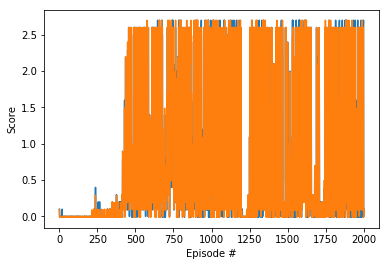

In [14]:
def td3(n_episodes=2000, max_t=100000):
    scores_deque = deque(maxlen=100)
    solved = False
    total_scores = []
    highest_score = float('-inf')
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        # Initialize noise reduction
        noise_degree = 2.0
        noise_decay = 0.999
        while True:
            actions = []
            for i in range(len(states)):
                actions.append(agents[i].act(states[i], True, noise_degree))
            noise_degree *= noise_decay
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done
            
            for i in range(num_agents):
                agents[i].step(states[i], actions[i], rewards[i], next_states[i], dones[i])

            states = next_states
            scores += rewards
            if np.any(dones):
                break
        scores_deque.append(np.max(scores))
        total_scores.append(scores)
        mean_score = np.mean(scores_deque)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, mean_score, np.max(scores)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score)) 
        if mean_score >= 0.5 and mean_score > highest_score and i_episode % 10 == 0:
            torch.save(agents[0].actor_local.state_dict(), 'actor1.pth')
            torch.save(agents[1].actor_local.state_dict(), 'actor2.pth')
            torch.save(agents[0].critic_local1.state_dict(), 'critic1.pth')
            torch.save(agents[0].critic_local2.state_dict(), 'critic2.pth')
            print('\rSave at {}\tAverage Score: {:.2f}'.format(i_episode, mean_score))
        if mean_score >= 0.5 and solved == False:
            solved = True
            torch.save(agents[0].actor_local.state_dict(), 'actor1.pth')
            torch.save(agents[1].actor_local.state_dict(), 'actor2.pth')
            torch.save(agents[0].critic_local1.state_dict(), 'critic1.pth')
            torch.save(agents[0].critic_local2.state_dict(), 'critic2.pth')
            print('\rSolved at Episode {} !\tAverage Score: {:.2f}'.format(i_episode, mean_score))
        highest_score = max(highest_score, mean_score)
    return total_scores

scores = td3()

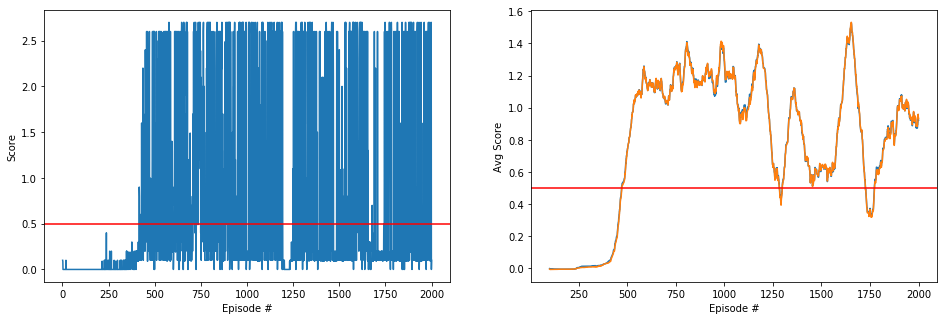

In [20]:
import pandas as pd

score_df = pd.DataFrame(scores)

fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(121)
plt.plot(np.arange(1, len(scores)+1), np.max(scores,axis=1))
plt.axhline(y=0.5, color='r', linestyle='-')
plt.ylabel('Score')
plt.xlabel('Episode #')

ay = fig.add_subplot(122)
plt.plot(np.arange(1, len(scores)+1), score_df.rolling(100).mean())
plt.axhline(y=0.5, color='r', linestyle='-')
plt.ylabel('Avg Score')
plt.xlabel('Episode #')

plt.show()

## Watch agent play

In [11]:
public_replay_buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
agents =[]
for i in range(num_agents):
    agents.append(TD3Agent(state_size=state_size, \
                 action_size=action_size, \
                 max_action=1.0, \
                 min_action=-1.0, 
                 memory=public_replay_buffer, \
                 random_seed=0))

for i in range(len(agents)):
    agents[i].actor_local.load_state_dict(torch.load('actor{}.pth'.format(i+1)))
    agents[i].critic_local1.load_state_dict(torch.load('critic1.pth'))
    agents[i].critic_local2.load_state_dict(torch.load('critic2.pth'))

In [13]:
for i in range(1, 3):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = []
        for i in range(len(states)):
            actions.append(agents[i].act(states[i], False))
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 2.600000038743019
Score (max over agents) from episode 1: 2.600000038743019


In [14]:
env.close()